We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

This time we build a language model that's character-level, not word level. 

In [1]:
!which python

/opt/conda/envs/pytorch/bin/python


In [2]:
!pwd

/home/ubuntu/sky_workdir/notebooks


Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.

In [3]:
import pandas as pd
import numpy as np
import ast


def clean_steps(data):
    data_list = ast.literal_eval(data)
    return ', '.join(data_list)


BOS, EOS = ' ', '\n'
data = pd.read_csv('RAW_recipes.csv')
data = data[['name', 'steps', 'description', 'ingredients']]
data = data[~data['steps'].str.contains('please ignore')]
data = data[~data['steps'].str.contains('none')]
data['steps'] = data['steps'].apply(clean_steps)
data['ingredients'] = data['ingredients'].apply(clean_steps)

lines = data.apply(lambda row: str(row['name']) + 
                   '; ' + 
                   str(row['steps']).replace("\n", ' ') + 
                   '; ' + 
                   str(row['description']) + 
                   '; ' + 
                   str(row['ingredients'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [4]:
# Get all unique characters from lines (including capital letters and symbols)
tokens = set(''.join(lines))
tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)

n_tokens =  142


We can now assign each character with its index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [5]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {token: idx for idx, token in enumerate(tokens)}

Our final step is to assemble several strings in a integer matrix with shape `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra `"EOS"` tokens or cropping long sequences. Here's how it works:

In [6]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [7]:
#Example: cast 4 random names to a single matrix, pad with zeros where needed.
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))

[[ 5 44 45 46  1  1  1  1  1  1  1  1  1  1  1]
 [ 5 44 45 44 46 44 45 44  1  1  1  1  1  1  1]
 [ 5 44 45 46 22 23 24 25 26 27 28 29 30 21  1]]


### Neural Language Model 

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


We can think of neural language models as neural classifiers. They classify prefix of a text into |V| classes, where the classes are vocabulary tokens.

Intuitively, neural Language Models do two things:

- **process context → model-specific**  
The main idea here is to get a vector representation for the previous context. Using this representation, a model predicts a probability distribution for the next token. This part could be different depending on model architecture (e.g., RNN, CNN, whatever you want), but the main point is the same - to encode context.  

- **generate a probability distribution for the next token → model-agnostic**  
Once a context has been encoded, usually the probability distribution is generated in the same way


When designing a CNN language model, keep in mind the following things:

- prevent information flow from future tokens  
To predict a token, a left-to-right LM has to use only previous tokens - make sure your CNN does not see anything but them! For example, you can shift tokens to the right by using padding.  

- do not remove positional information  
Differently from text classification, positional information is very important for language models. Therefore, do not use pooling (or be very careful in how you do it).  
 
- if you stack many layers, do not forget about residual connections  
If you stack many layers, it may difficult to train a very deep network well. To avoid this, use residual connections  

1. Initialize the embedding layer to transform token indices into embeddings.
2. Add zero padding on the left to prevent the model from seeing future tokens.
3. Implement the convolutional layers, ensuring they only consider the current and previous words.
4. Include residual connections if using multiple layers.
5. Add a final layer to transform the output to the desired size.
6. Implement the forward pass, ensuring the input and output dimensions are compatible with embeddings and convolutions.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# device cuda if available else cpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [23]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens, emb_size=16, hid_size=64, filter_size=5, stride_size=1):
        super().__init__()

        # Embedding layer
        self.emb = nn.Embedding(n_tokens, emb_size)

        # Left padding to prevent future information leakage
        total_padding_needed = sum([(filter_size - 1) for _ in range(3)])
        self.left_padding = total_padding_needed


        # Convolutional layers with padding to maintain sequence length
        self.convs = nn.Sequential(
            nn.ZeroPad2d((self.left_padding, 0, 0, 0)),
            nn.Conv1d(emb_size, hid_size, kernel_size=filter_size, stride=stride_size, padding=0),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=filter_size, stride=stride_size, padding=0),
            nn.ReLU(),
            nn.Conv1d(hid_size, n_tokens, kernel_size=filter_size, stride=stride_size, padding=0)
        )

    def forward(self, input_ix):
        # Embedding input tokens
        emb = self.emb(input_ix).permute(0, 2, 1)  # [batch_size, emb_size, sequence_length]

        # Applying convolutions
        conv_out = self.convs(emb)

        # Adjusting shape for output
        output = conv_out.permute(0, 2, 1)  # [batch_size, sequence_length, n_tokens]
        return output
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))


In [12]:
dummy_model = FixedWindowLanguageModel(n_tokens=len(tokens))

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('emb.weight', 'convs.1.weight', 'convs.1.bias', 'convs.3.weight', 'convs.3.bias', 'convs.5.weight', 'convs.5.bias')


In [13]:
dummy_logits.shape

torch.Size([3, 15, 142])

In [14]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens)
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs"

In [15]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

The output from above. Let's break down what each part of this output represents:

1. **Embedding Layer**:
   - `'emb.weight'`: This is the weight matrix of the embedding layer. Each row corresponds to the embedding of a token in your vocabulary.

2. **Convolutional Layers**:
   - `'convs.X.1.weight'` and `'convs.X.1.bias'`: These are the weights and biases for the convolutional layers. `X` varies from 0 to 2, representing each convolutional layer in your `self.convs` ModuleList.
   - `'convs.X.3.weight'` and `'convs.X.3.bias'`: These represent the weights and biases for the batch normalization layers following each convolutional layer.

3. **Residual Layers**:
   - `'residual_layers.X.weight'` and `'residual_layers.X.bias'`: These are the weights and biases for the linear layers in your `self.residual_layers` ModuleList, used to match the dimensions for the residual connections.

4. **Final Linear Layer**:
   - `'final_layer.weight'` and `'final_layer.bias'`: These are the weights and biases of the final linear layer that outputs the logits for each token in the vocabulary.

This output shows that all the expected parameters for model's layers are correctly instantiated and registered within the model. Each layer's weights and biases are part of the model's parameters, which will be learned during training. 

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [18]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

In [10]:
def compute_loss(model, input_ix):
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64).to(device)

    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]

    # Compute the mask
    mask = compute_mask(input_ix)

    # Compute cross-entropy loss
    loss = F.cross_entropy(logits.transpose(1, 2), reference_answers, reduction='none')

    # Apply the mask - zero out losses where mask is 0
    masked_loss = loss * mask[:, 1:].to(loss.dtype)

    # Compute mean loss, but only over non-zero elements in the mask
    loss = masked_loss.sum() / mask[:, 1:].sum()

    return loss

Note that the mask is shifted one position to the right compared to logits and reference_answers to align correctly (excluding the first token which has no previous token to predict from). The `F.cross_entropy` function expects logits of shape `[batch_size, num_classes, sequence_length]` and reference answers of shape `[batch_size, sequence_length]`, hence the `logits.transpose(1, 2)`.

The loss is calculated for each token, then masked to exclude unwanted tokens (padding and subsequent `EOS` tokens), and finally, the mean loss is computed over all remaining (non-masked) tokens. This ensures that the loss is properly normalized only over the relevant tokens.

In [ ]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

### Evaluation

I need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [11]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [25]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
model = FixedWindowLanguageModel(n_tokens=n_tokens)
opt = torch.optim.Adam(model.parameters())

model = model.to(device)

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'one spoon of'))

Sample before training: one spoon of°]4¼½,t,°x>õdt	)ä„¯…çà{€%z`t'óöjò­]_üîvsô–′7f¥5f,ç4‘ñh<ây¡@é`o2£‘ú2gc|kq



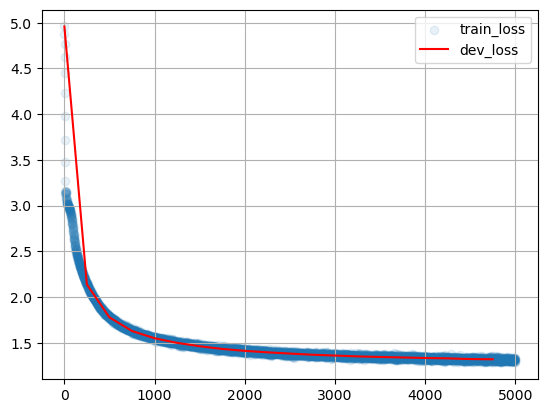

Generated examples (tau=0.5):
 lightly and coat each coarte pan, cook until smooth, cover with for 1 hour over the cook until the c
 has beans , until for to coat the butter and stir in the eggs , salt and pepper , add the potatoes a
 mushrooms , and cream cheese, pepper , salt and pepper, cook , or a greased makes a salt cooked wate
Scoring dev...


100%|██████████| 4950/4950 [24:23<00:00,  3.38it/s]

#4999 Dev loss: 1.313


In [28]:
from IPython.display import clear_output
from random import sample
from tqdm import trange
import matplotlib.pyplot as plt

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    batch = torch.as_tensor(batch, dtype=torch.int64).to(device)
    
    
    loss_i = compute_loss(model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])

In [29]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(100):
    print(generate(model, temperature=0.5))

Final dev loss: 1.3130836025581651
 coasted sugar, salt, cup kins, place on a few minutes and serve with a recipe for about 50 minutes, 
 greased cook and bring to a boil , add the shredients and cook over medium-high heat , stirring of t
 mixture to a boil , remove prepare flavor the from the heat and stir in the soup with a cume for abo
 baking pan, canden pepper, salt, milk , and a large bowl , combine cake for 1-1 / 2-1 / 2 cup of the
 well best browned, add the butter cook until smooth, baking powder, salt, pepper

 from the carrots , stirring occasionally add the strawberries; part and sugar and cooking the chips 
 chicken broth, bake in 350 for 20 minutes, remove from breasts in the boil and cook until well bette
 by favorite to purpose flour, salt, pepper, salt, preheated milk, serve with pastic and chocolate ch
 add the pepper, stir in pan and let as medium heat until the flavorite recipe from the oven to 400 d
 firm back read; sugar, salt, cheese and cook for 10 minutes or un

In [30]:
# Save the model 
torch.save(model.state_dict(), 'model.pt')

### RNN Language Models 

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [12]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256, num_layers=2, dropout=0.5):
        """
        A recurrent language model with multiple LSTM layers and dropout.
        
        Parameters:
            - n_tokens: Vocabulary size
            - emb_size: Size of the embedding vector for each token
            - hid_size: Size of the hidden state in the LSTM layers
            - num_layers: Number of LSTM layers to stack
            - dropout: Dropout probability to apply after each LSTM layer
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.

        self.emb = nn.Embedding(n_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, hid_size, num_layers=num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.hid_to_logits = nn.Linear(hid_size, n_tokens)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ix):

        # Compute token embeddings
        input_emb = self.emb(input_ix)

        # Apply RNN
        rnn_out, _ = self.rnn(input_emb)

        # Apply dropout
        rnn_out = self.dropout(rnn_out)

        # Compute logits
        logits = self.hid_to_logits(rnn_out)

        return logits
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()

        return dict(zip(tokens, probs))


In [13]:
model = RNNLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('emb.weight', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'rnn.weight_ih_l1', 'rnn.weight_hh_l1', 'rnn.bias_ih_l1', 'rnn.bias_hh_l1', 'hid_to_logits.weight', 'hid_to_logits.bias')


In [14]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

AssertionError: your model's predictions depend on FUTURE tokens.  Make sure you don't allow any layers to look ahead of current token. You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test.

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [ ]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 64         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 250
train_history, dev_history = [], []

model = RNNLanguageModel().to(device)
opt = torch.optim.Adam(model.parameters())

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))

In [20]:
print("Sample before training:", generate(model, 'one spoon of'))

Sample before training: one spoon of~‘¾fª;¾ëßa$3‹e‘\x+.ò=¥,+@%û¤;1€p4&`>•`ç]êš150£êôñ{ñ♥‚ºà`[|⁄ò1\⁄′êbòfömij€ú£¼6/’á2öåõi`


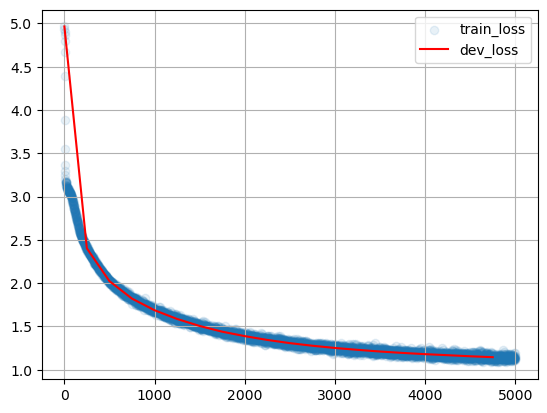

Generated examples (tau=0.5):
 silsler cookbook bean cheese chickes; preheat oven to 350 degrees, while sherry , combine the halves
 chicken in another saucepan  pan and sour; stir in chocolate chips, place in skillet , parmesan pape
 strips and sauce and poult meat in cookies; i found the chicken into the warm patty sharp powder and
Scoring dev...


100%|██████████| 4950/4950 [1:31:03<00:00,  1.10s/it]

#4999 Dev loss: 1.135


In [22]:
from IPython.display import clear_output
from random import sample
from tqdm import trange
import matplotlib.pyplot as plt

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    batch = torch.as_tensor(batch, dtype=torch.int64).to(device)

    loss_i = compute_loss(model, batch)

    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])

In [24]:
# Save the model 
torch.save(model.state_dict(), 'model_rnn.pt')

Generated examples (tau=0.5):
 arsl bon teae boah in tire aate tedite fote sretoe cess sed caual csare ion  innl ooe con , bhee bue
  2%|▏         | 100/4950 [00:44<42:24,  1.91it/s] esto p tre tonus sesm al, bhesite rerilh bor fl tote bouk oon coe loe coes on bn cor ter aed  avsr p
 &aaeae acc sn pot pted aome, sonte monsd tod coces oil vre inea supat nr toh aln  fe tl aud dhet loe
  2%|▏         | 108/4950 [00:47<30:57,  2.61it/s]

Generated examples (tau=0.5):
 saut to the aprentire the heat pocker, slice and mowlers framasad salt mide a bould sauce a sart or 
 10%|█         | 500/4950 [09:06<43:29,  1.71it/s] for corested and seming of the minutes, red and the dedered hear , and depper sitin to rice bo lerce
 tor the back and and to garlic and perres , cool onion the fand in 1 bake coult add a sheat to the a
 10%|█         | 513/4950 [09:12<30:19,  2.44it/s]

 Generated examples (tau=0.5):
 gord cheese from ingrondeas of pould and serve in the read and remaice flour, spinet cimes  is in fl
 20%|██        | 1000/4950 [18:14<43:52,  1.50it/s] chill cooking salt and poar on tho cooked to the lish mixture of tunden the the buther the eggs, ser
 grome water collon as a hancarch to a thicken at the cooking strips for 1 2 mind for to 2 minutes on
 20%|██        | 1009/4950 [18:19<30:59,  2.12it/s]

Generated examples (tau=0.5):
 waters: to the coully continue chicken on dound sopet , mix and cool and sugar of the place over the
 40%|████      | 2000/4950 [36:25<32:39,  1.51it/s] spread tranblecti; add thickened from fry, pour the chicken , as the right and but with sprinkle and
 bake dink or and apall with cheddar peas and heet cook blanch for 20 milut in a carbon of the ciname
 41%|████      | 2034/4950 [36:39<18:35,  2.61it/s]

 Generated examples (tau=0.5):
 carrots to dry hest tho simmer; pour the tomatoes and very the thick and chopped and read the layere





In [23]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(100):
    print(generate(model, temperature=0.5))

Final dev loss: 1.1349796967684016
 green pepper bacon crust; cook with a cottage cheese, serve warm, salt and pepper in a saucepan over
 more batter salad and ensain lighels; plta piece of the sunday and bake for about 30 minutes or unti
 sauce caresul chicken served butter sho the chips; pretaro water in a large skillet , set aside, pla
 beef pieces; preheat oven to 350f, butter half in a large bowl , combine and then sprinkle with choo
 chocolate sauce   year and salsa; in a bowl and place in a large bowl , combine the chicken , and th
 shape and coloring  bean grahot butter legly; in a large bowl, combine the oil and chicken, in a lar
 my wast water sauce and wine nich; remove from heat and season with salt and pepper and sprinkle in 
 bread sprinkling in the chocolate chips  according pork chips; combine the fresh cheese and salt, st
 salsa sauce; place the addities on the sauce in a smill bowl, cover and let stand for 20 minutes or 
 sandwiches  blughes s carrots; preheat oven to

### Alternative sampling strategies

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize: 
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleus sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleus N=0.9, the nucleus words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleus words, you need to re-normalize them as in top-k sampling and generate the next token.

__Task__: implement nucleus sampling variant and see if it is any good.

In [25]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleus sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix
    
    :note: make sure that nucleus always contains at least one word, even if p(w*) > nucleus
    
    """
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        sorted_probs, sorted_tokens = zip(*sorted(zip(probs, tokens), reverse=True))
        sorted_probs = np.array(sorted_probs)
        sorted_probs /= sorted_probs.sum()
        sorted_probs = np.cumsum(sorted_probs)
        sorted_tokens = np.array(sorted_tokens)
        if nucleus < sorted_probs[0]:
            next_token = sorted_tokens[0]
        else:
            next_token = sorted_tokens[sorted_probs < nucleus][-1]

In [28]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.9))

### Beam Search 

At times, you don't really want the model to generate diverse outputs as much as you want a __single most likely hypothesis.__ A single best translation, most likely continuation of the search query given prefix, etc. Except, you can't get it. 

In order to find the exact most likely sequence containing 10 tokens, you would need to enumerate all $|V|^{10}$ possible hypotheses. In practice, 9 times out of 10 you will instead find an approximate most likely output using __beam search__.

Here's how it works:
0. Initial `beam` = [prefix], max beam_size = k
1. for T steps:
2. ` ... ` generate all possible next tokens for all hypotheses in beam, formulate `len(beam) * len(vocab)` candidates
3. ` ... ` select beam_size best for all candidates as new `beam`
4. Select best hypothesis (-es?) from beam


In [1]:
import heapq

def generate_beamsearch(model, prefix=BOS, beam_size=4, length=5):
    """
    Generate a sequence with beam search.
    
    :param model: The language model
    :param prefix: A string containing space-separated previous tokens
    :param beam_size: The number of sequences to keep at each step
    :param length: Generate sequences with at most this many tokens, NOT INCLUDING PREFIX
    
    :returns: beam_size most likely sequence candidates as a list of tuples (score, sequence)
    """
    # Initialize the beam with the prefix
    beam = [(0, prefix)]
    
    # Loop over the sequence length to generate
    for _ in range(length):
        candidates = []
        
        # Expand each sequence in the beam
        for score, seq in beam:
            # Convert the sequence to a tensor
            input_ix = torch.as_tensor(to_matrix([seq]), dtype=torch.int64).to(device)
            
            # Get the log probabilities of the next tokens
            with torch.no_grad():
                logits = model(input_ix)[0, -1]  # Get the logits for the last time step
                log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
            
            # Get the top beam_size next tokens and their log probabilities
            topk_probs, topk_indices = torch.topk(log_probs, beam_size)
            
            # Add these new sequences to the candidates list
            for i in range(beam_size):
                token = tokens[topk_indices[i]]  # Map the index back to the actual token
                prob = topk_probs[i].item()
                new_seq = seq + ' ' + token
                candidates.append((score + prob, new_seq))
        
        # Select the top beam_size sequences
        beam = heapq.nlargest(beam_size, candidates, key=lambda x: x[0])
    
    # Return the top sequences and their scores
    return beam


NameError: name 'BOS' is not defined

In [ ]:
generate_beamsearch(model, prefix=' deep ', beam_size=4)

In [ ]:
# check it out: which beam size works best?
# find at least 5 prefixes where beam_size=1 and 8 generates different sequences

### Bonus quest II: Ultimate Language Model

I learned the building blocks of neural language models, and now can build the ultimate monster:  
* Make it char-level, word level or maybe use sub-word units like [bpe](https://github.com/rsennrich/subword-nmt);
* Combine convolutions, recurrent cells, pre-trained embeddings and all the black magic deep learning has to offer;
  * Use strides to get larger window size quickly. Here's a [scheme](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif) from google wavenet.
* Train on large data. Like... really large. Try [1 Billion Words](http://www.statmt.org/lm-benchmark/1-billion-word-language-modeling-benchmark-r13output.tar.gz) benchmark;
* Use training schedules to speed up training. Start with small length and increase over time; Take a look at [one cycle](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for learning rate;